In [88]:
!cd build && make -j

[ 20%] Built target ring-nonblocking.exe
[ 50%] Built target laplace-seq.exe
[100%] Built target laplace-par.exe
[100%] Built target scatter-gather-max.exe


In [89]:
NS = list(range(20, 1231, 50))
EXEC_SEQ = ["./build/laplace-seq.exe"]
EXEC_PAR = ["mpiexec", "-n", "10", "./build/laplace-par.exe"]

In [90]:
import re

TIME_RE = re.compile(r'Statistics: duration\(s\)=(\d+\.\d+) #iters=(\d+) diff=(\d+\.\d+) epsilon=(\d+\.\d+)')

_s = "Statistics: duration(s)=1.7463130951 #iters=9067 diff=0.0000913513 epsilon=0.0000964947"
assert TIME_RE.match(_s).groups() == ('1.7463130951', '9067', '0.0000913513', '0.0000964947')

In [91]:
import subprocess
from tqdm import tqdm

columns = ["n", "exe", "duration", "iters", "diff", "epsilon"]
statistics = []

for n in tqdm(NS):
    # print(f"n={n}")
    for exe_type, exe in zip([SEQ := "sequential", PAR := "parallel"], [EXEC_SEQ, EXEC_PAR]):
        # print(f"  {exe}")
        for i in range(3):
            out = subprocess.run([*exe, str(n)], capture_output=True, text=True)
            m = TIME_RE.match(out.stderr)
            assert m, out
            # print(f"    {m.groups()}")
            duration, iters, diff, epsilon = m.groups()
            statistics.append((n, exe_type, float(duration), int(iters), float(diff), float(epsilon)))
        # print()

100%|██████████| 25/25 [1:09:59<00:00, 167.96s/it]


In [92]:
import pandas as pd

df = pd.DataFrame(statistics, columns=columns)

In [93]:
df

,n,exe,duration,iters,diff,epsilon
0,20,sequential,0.000588,179,0.000007,0.000007
1,20,sequential,0.000312,179,0.000007,0.000007
2,20,sequential,0.000364,179,0.000007,0.000007
3,20,parallel,0.000595,179,0.000007,0.000007
4,20,parallel,0.000699,179,0.000007,0.000007
...,...,...,...,...,...,...
145,1220,sequential,70.278929,7724,0.000389,0.000389
146,1220,sequential,69.881241,7724,0.000389,0.000389
147,1220,parallel,43.413711,7724,0.000389,0.000389
148,1220,parallel,44.120815,7724,0.000389,0.000389


In [94]:
sanity_check = df.groupby(["exe", "n"]).agg({"iters": "nunique", "diff": "nunique", "epsilon": "nunique"})
assert sanity_check.eq(1).all().all()

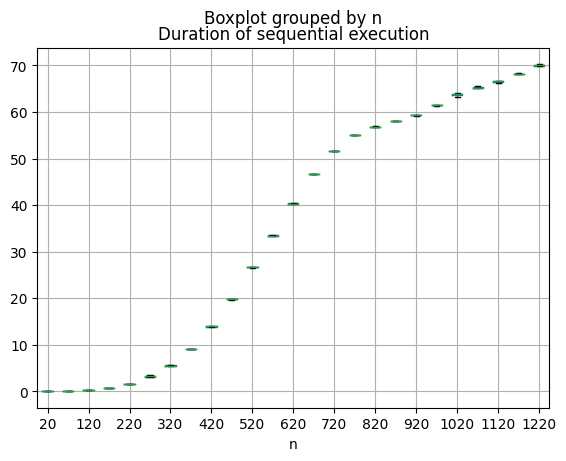

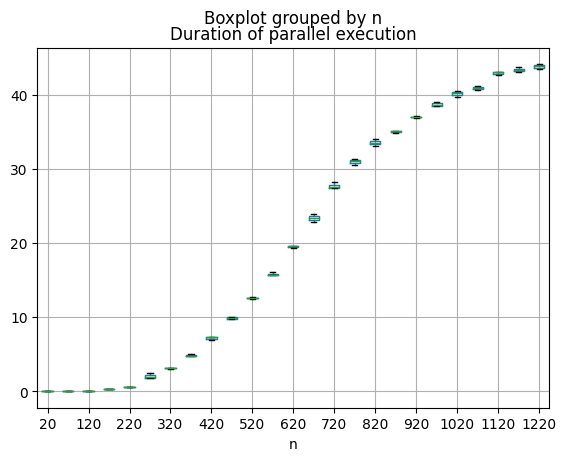

In [99]:
from matplotlib import pyplot as plt

exes = df["exe"].unique()
for exe in exes:
    data = df[df["exe"] == exe]
    data.boxplot(column="duration", by="n")
    plt.title(f"Duration of {exe} execution")
    ax = plt.gca()
    ax.set_xticks(ax.get_xticks()[::2])
    plt.savefig(f"duration_{exe}.png")